### **INTERPRETABILIDAD DE SCORING CREDITICIO**

#### <strong><font color="green">🎯 Objetivo</font></strong>

Comparar el rendimiento de dos modelos de regresión logística: uno con regularización **L1 (Lasso)** y otro con **L2 (Ridge)**, aplicados al dataset de riesgo crediticio. Evaluar métricas de desempeño e interpretabilidad con **SHAP.**

Desarrollar un modelo predictivo para el scoring crediticio, evaluando su rendimiento y la capacidad de interpretación de sus decisiones. Los estudiantes implementarán un modelo de clasificación con regularización y emplearán técnicas de interpretabilidad como SHAP o LIME para explicar el comportamiento del modelo

#### <strong><font color="green">Entorno de ejecución.</font></strong>

Para este proyecto se utilizará el entorno de ejecución de Jupyter Notebook. La versión de python es la 3.12.10 con las siguientes librerías:

- numpy==1.26.4
- pandas==2.2.2
- scipy==1.11.4
- matplotlib==3.9.2
- seaborn==0.13.2
- plotly==5.24.1
- scikit-learn==1.7.1
- shap==0.48.0

In [41]:
# Se importan las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import funciones as f
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import shap

import warnings
warnings.filterwarnings('ignore')

#### <strong><font color="green">1. Análisis del dataset y comprensión del problema</font></strong>

In [42]:
# Cargar datos
credit = fetch_openml(name = 'credit', version = 1, as_frame = True)
df = credit.frame.copy()

In [43]:
# Ver dataset
df

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,0.006999,38.0,0.0,0.302150,5440.0,4.0,0.0,1.0,0.0,3.0,0.0
1,0.704592,63.0,0.0,0.471441,8000.0,9.0,0.0,1.0,0.0,0.0,0.0
2,0.063113,57.0,0.0,0.068586,5000.0,17.0,0.0,0.0,0.0,0.0,0.0
3,0.368397,68.0,0.0,0.296273,6250.0,16.0,0.0,2.0,0.0,0.0,0.0
4,1.000000,34.0,1.0,0.000000,3500.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
16709,1.000000,46.0,0.0,170.398010,401.0,3.0,2.0,0.0,0.0,2.0,1.0
16710,1.135552,41.0,2.0,0.845887,7500.0,12.0,0.0,4.0,1.0,0.0,1.0
16711,0.920107,31.0,1.0,0.176732,1125.0,4.0,1.0,0.0,0.0,0.0,1.0
16712,0.983825,55.0,0.0,0.064116,4600.0,2.0,1.0,0.0,0.0,6.0,1.0


In [44]:
# Exploración básica del dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16714 entries, 0 to 16713
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  16714 non-null  float64
 1   age                                   16714 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  16714 non-null  float64
 3   DebtRatio                             16714 non-null  float64
 4   MonthlyIncome                         16714 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       16714 non-null  float64
 6   NumberOfTimes90DaysLate               16714 non-null  float64
 7   NumberRealEstateLoansOrLines          16714 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  16714 non-null  float64
 9   NumberOfDependents                    16714 non-null  float64
 10  SeriousDlqin2yrs                      16714 non-null  float64
dtypes: float64(11)


In [45]:
# Estadísticas descriptivas
print(df.describe(include = "all"))

       RevolvingUtilizationOfUnsecuredLines           age  \
count                          16714.000000  16714.000000   
mean                               4.799862     48.798672   
std                              204.062345     13.906078   
min                                0.000000     21.000000   
25%                                0.082397     38.000000   
50%                                0.443080     48.000000   
75%                                0.926637     58.000000   
max                            22000.000000    101.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                          16714.000000  16714.000000   16714.000000   
mean                               1.110267     30.980298    6118.120258   
std                                7.172890    719.694859    5931.841779   
min                                0.000000      0.000000       0.000000   
25%                                0.000000      0.155971    3128.5000

In [46]:
# Análisis calidad de datos
analysis_result = f.data_quality_analysis(df).set_index('Columna')
print(analysis_result.sort_values('Tipo de dato'))

                                     Tipo de dato  Valores únicos  \
Columna                                                             
RevolvingUtilizationOfUnsecuredLines      float64           13887   
age                                       float64              78   
NumberOfTime30-59DaysPastDueNotWorse      float64              16   
DebtRatio                                 float64           16128   
MonthlyIncome                             float64            5150   
NumberOfOpenCreditLinesAndLoans           float64              48   
NumberOfTimes90DaysLate                   float64              18   
NumberRealEstateLoansOrLines              float64              20   
NumberOfTime60-89DaysPastDueNotWorse      float64              12   
NumberOfDependents                        float64               9   
SeriousDlqin2yrs                          float64               2   

                                      Valores nulos  % nulos  
Columna                                


📊 Distribución de variables


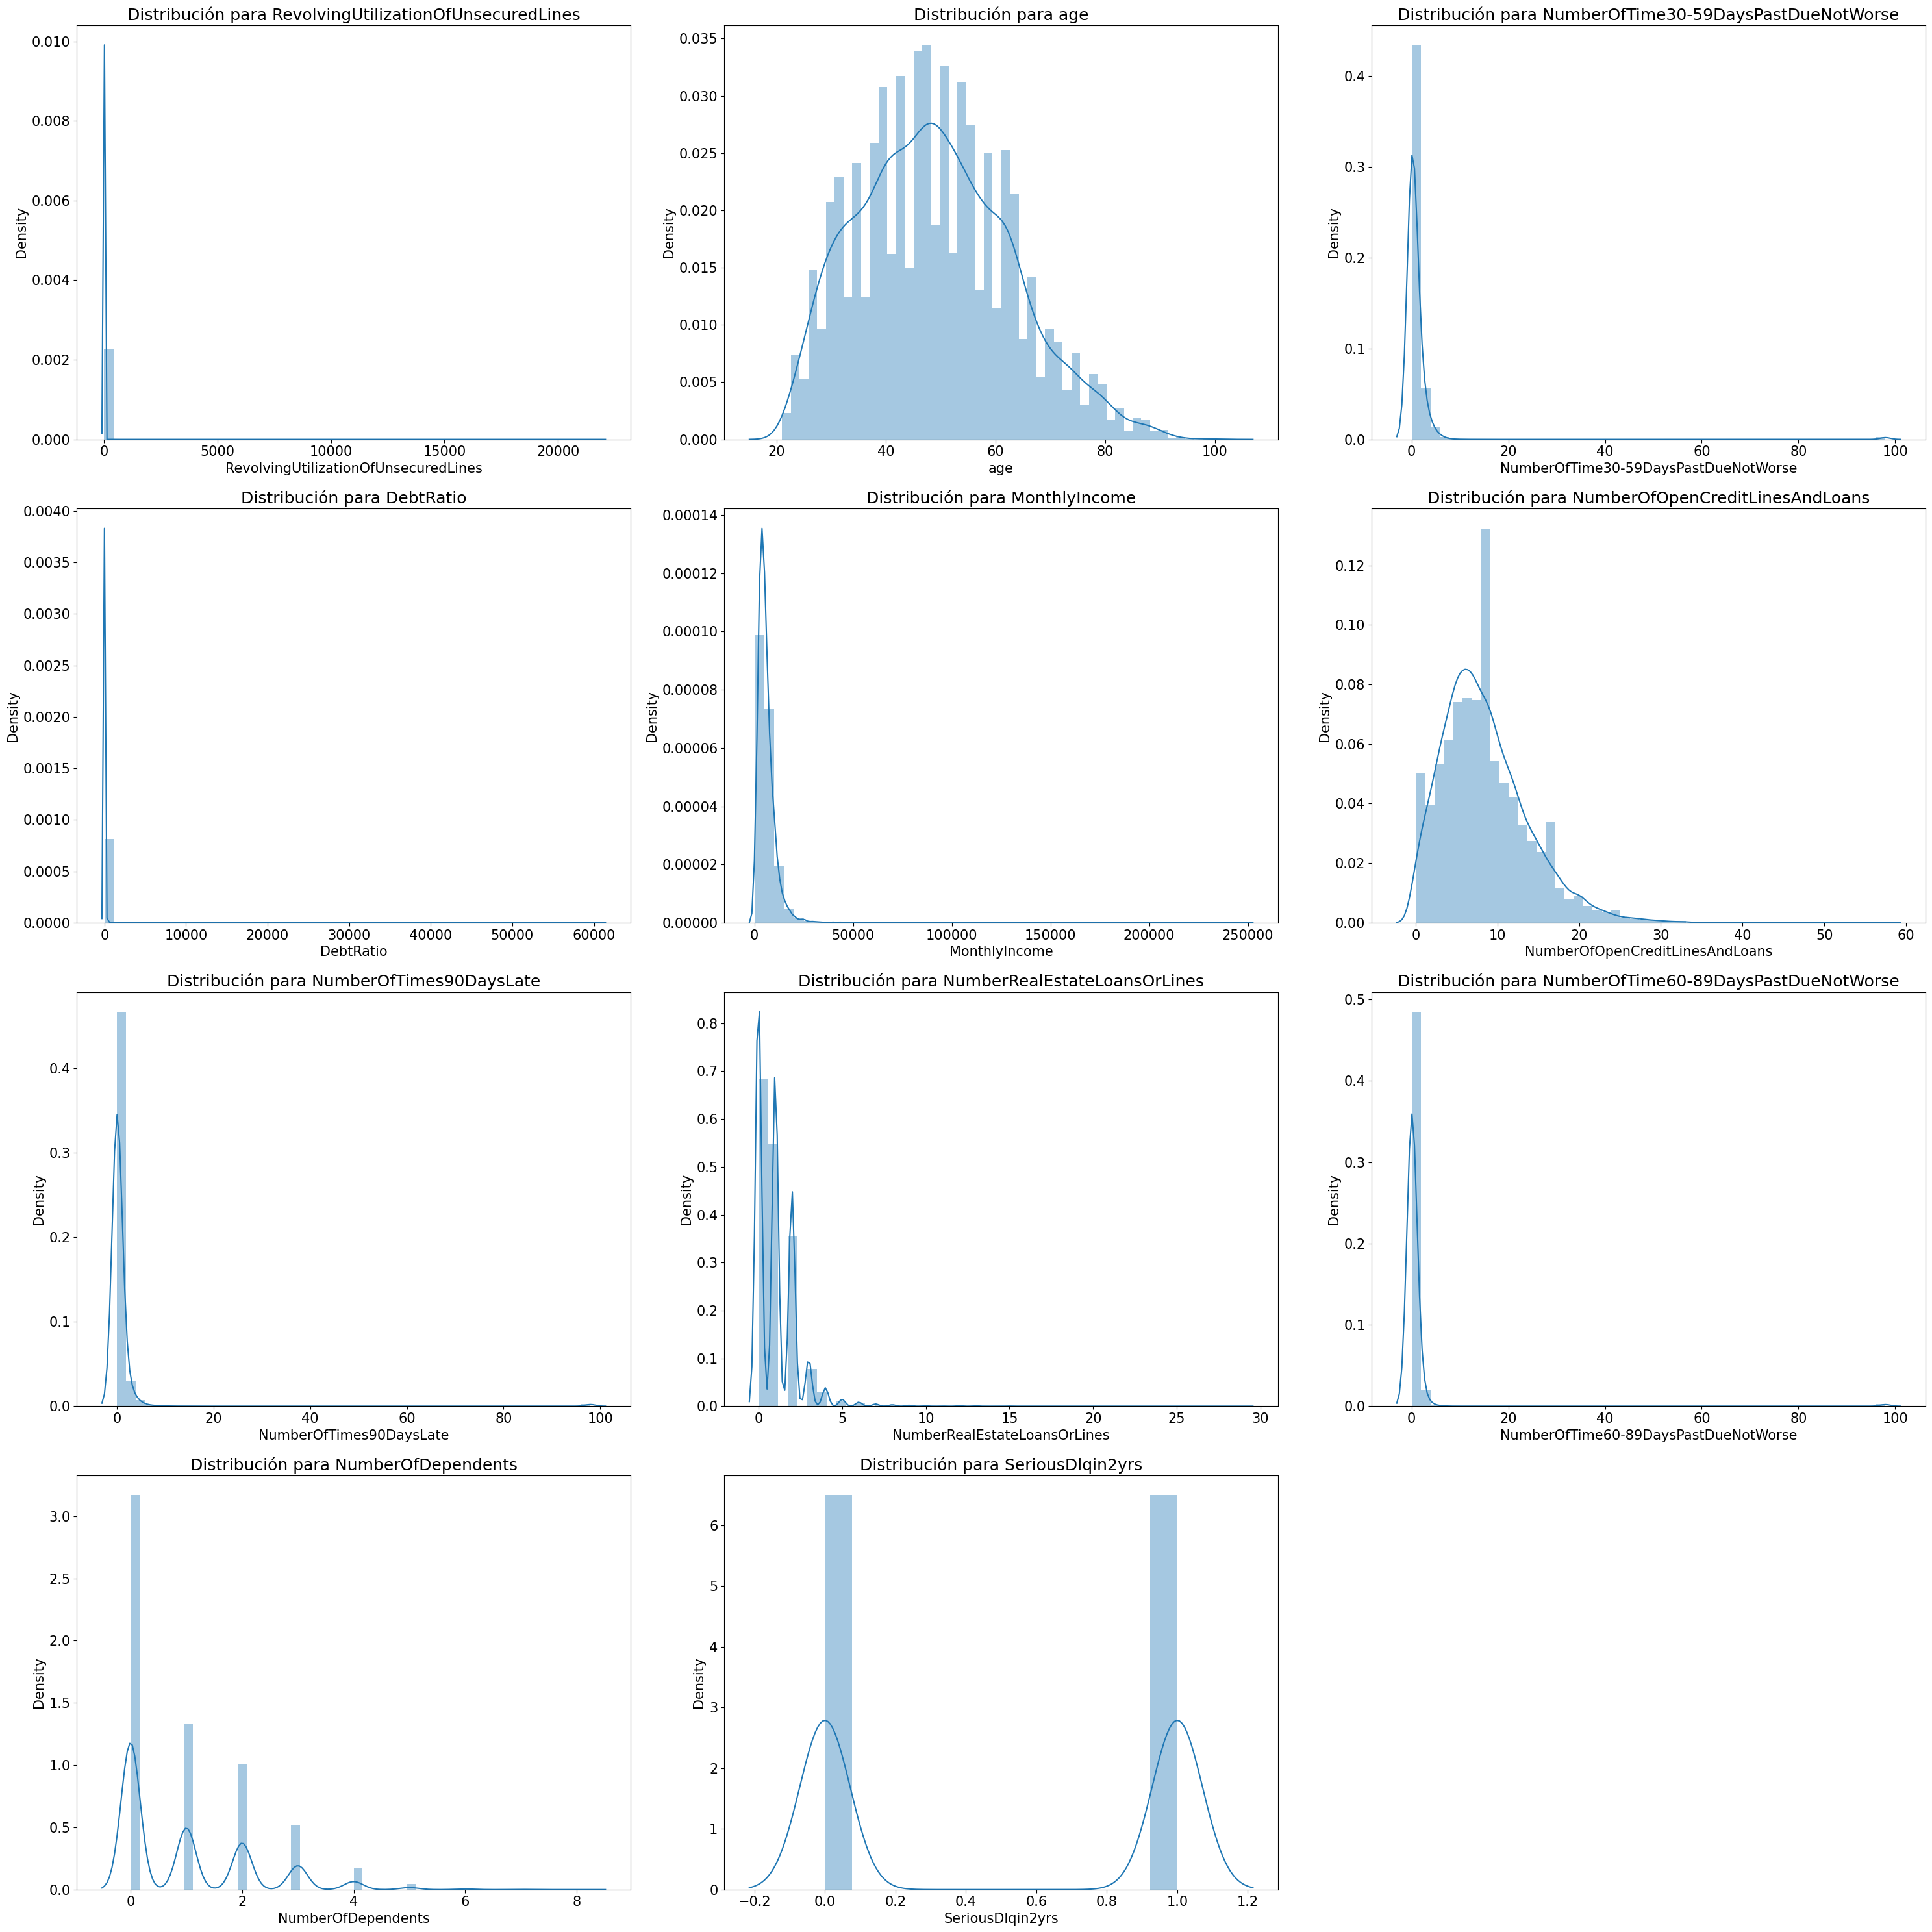

In [47]:
# Análisis exploratorio de datos
# Imprime un encabezado para indicar el inicio del análisis de distribución de variables
print(f"\n📊 Distribución de variables")

# Aumenta el tamaño de fuente de todos los gráficos para mejorar la visualización
plt.rcParams.update({'font.size': 15})

# Define el tamaño general de la figura que contendrá todos los subgráficos
plt.figure(figsize = (30, 30))

# Itera sobre todas las columnas del DataFrame para graficar su distribución
for n, i in enumerate(list(df.columns)):
    # Crea un subplot en una grilla de 4 filas x 3 columnas en la posición correspondiente
    plt.subplot(4, 3, n + 1)

    # Si la columna es categórica (tipo object), se usa un gráfico de barras
    if analysis_result.loc[i, 'Tipo de dato'] == 'object':
        # Cuenta y grafica las frecuencias de las 7 categorías más comunes
        sns.countplot(y=df[i], order=df[i].value_counts().iloc[:7].index)
        plt.title('Frecuencias para {}'.format(i))  # Título del gráfico

    else:
        # Si la columna es numérica, se usa un histograma con curva de densidad
        sns.distplot(df[i])
        plt.title('Distribución para {}'.format(i))  # Título del gráfico

    # Ajusta el layout del gráfico para evitar sobreposiciones
    plt.tight_layout()

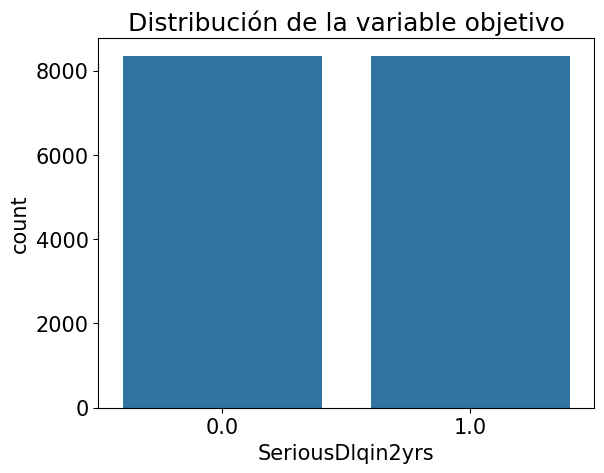

In [48]:
# Ver distribución de la variable objetivo
sns.countplot(x = 'SeriousDlqin2yrs', data = df)
plt.title('Distribución de la variable objetivo')
plt.show()

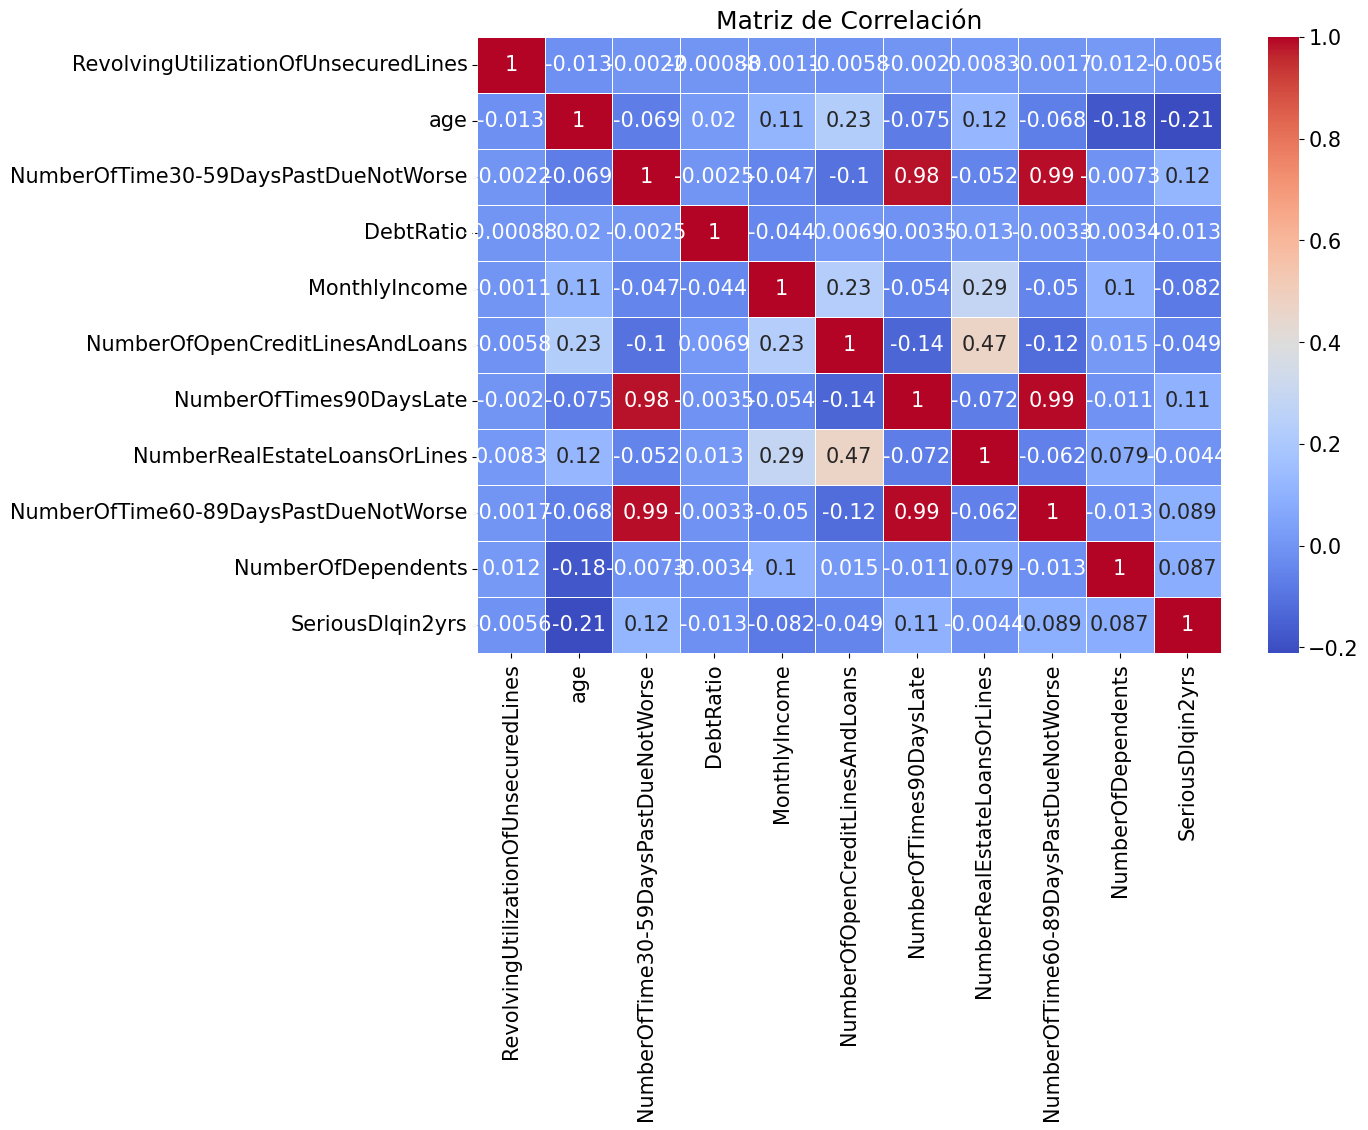

In [49]:
# Crea variable de matriz de correlación entre las variables numéricas
correlation_matrix = df.select_dtypes(include = ['float64', 'int64']).corr()

# Gráfica de correlación
plt.figure(figsize = (12, 8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5)
plt.title('Matriz de Correlación')
plt.show()


📊 Correlación de variables con objetivo ('SeriousDlqin2yrs')


<Axes: >

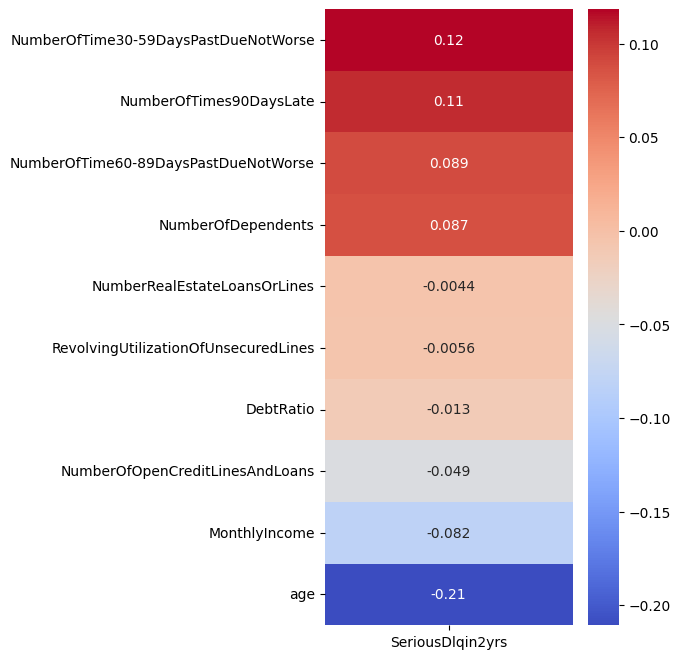

In [50]:
# Gráfico de valores de correlación respecto a "SeriousDlqin2yrs"
print(f"\n📊 Correlación de variables con objetivo ('SeriousDlqin2yrs')")
plt.rcParams.update({'font.size': 10})
plt.figure(figsize = (4, 8))
sns.heatmap(correlation_matrix.loc[:, ['SeriousDlqin2yrs']].sort_values('SeriousDlqin2yrs', ascending = False).iloc[1:], cmap = 'coolwarm', annot = True)

📊 **Análisis Exploratorio de Variables y Generación de Hipótesis**

🔍 **Distribución de Variables**

- **Variables sesgadas positivamente (asimetría a la derecha)**:  
   - `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`, `MonthlyIncome`, `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`.

  Estas variables tienen muchos valores bajos y unos pocos valores extremadamente altos. Indican que:
  - Muchos clientes usan poco sus líneas de crédito.
  - Pocos clientes presentan altos niveles de deuda o morosidad.

- **Variables aproximadamente normales**:  
   - `age` tiene una distribución cercana a normal entre los 20 y 80 años.

- **Variable objetivo (`SeriousDlqin2yrs`)**:  
   - Su distribución está **balanceada**, es decir, hay una proporción similar de casos con y sin incumplimiento, lo que es ideal para tareas de clasificación.

---

📈 **Correlación con la Variable Objetivo**

| Variable                                 | Correlación con `SeriousDlqin2yrs` |
|------------------------------------------|------------------------------------|
| `NumberOfTime30-59DaysPastDueNotWorse`  | **0.12**                           |
| `NumberOfTimes90DaysLate`               | **0.11**                           |
| `NumberOfTime60-89DaysPastDueNotWorse`  | **0.089**                          |
| `NumberOfDependents`                    | **0.087**                          |
| `age`                                   | **-0.21**                          |
| `MonthlyIncome`                         | -0.082                             |
| `NumberOfOpenCreditLinesAndLoans`       | -0.049                             |

---

💡 **Hipótesis Generadas**

1. **Historial de morosidad aumenta el riesgo crediticio**  
   Las variables relacionadas con pagos atrasados presentan la mayor correlación positiva con el riesgo de incumplimiento.  
   **Hipótesis**: A mayor número de pagos atrasados, mayor probabilidad de incumplimiento futuro.

2. **La edad tiene relación inversa con el riesgo**  
   `age` tiene la correlación negativa más alta.  
   **Hipótesis**: Personas mayores tienden a ser más estables financieramente y presentan menor riesgo.

3. **Mayores ingresos podrían reducir el riesgo**  
   Aunque la correlación no es fuerte, es negativa.  
   **Hipótesis**: Clientes con mayores ingresos tienen más capacidad de pago.

4. **Mayor número de dependientes podría aumentar el riesgo**  
   **Hipótesis**: Las responsabilidades económicas adicionales afectan la capacidad de pago del cliente.

5. **Uso extremo de crédito podría indicar riesgo**  
   A pesar de su baja correlación, las variables como `RevolvingUtilizationOfUnsecuredLines` tienen valores extremos que podrían ser importantes en modelos no lineales.  
   **Hipótesis**: Clientes que usan intensamente sus líneas de crédito sin pagarlas representan un mayor riesgo, aunque son menos frecuentes.

---

### 🧠 Recomendaciones para Modelado

- Priorizar las siguientes variables:  
  `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`, `age`, `NumberOfDependents`.

- Aplicar técnicas de regularización o selección de características para validar empíricamente estas hipótesis.

- Considerar escalar variables sesgadas y manejar valores extremos con precaución.

---

#### <strong><font color="green">2. Preprocesamiento de datos</font></strong>

In [51]:
# Separación de variables predictoras (X) y objetivo (y)
X = df.drop(columns = 'SeriousDlqin2yrs')      # Variables predictoras
y = df['SeriousDlqin2yrs'].astype(int)         # Variable objetivo

In [52]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [53]:
# Escalar variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)      # Solo ajusta con datos de entrenamiento
X_test_scaled = scaler.transform(X_test)            # Aplica misma transformación al conjunto de prueba

In [54]:
# Ver cantidad de datos de entrenamiento y prueba
print("Cantidad de datos:")
print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

Cantidad de datos:
Train: (13371, 10), Test: (3343, 10)


#### <strong><font color="green">3. Entrenamiento de modelos</font></strong>

##### <strong><font color="DarkSeaGreen">🔸Regresión Logística con Regularización L1 (Lasso)</font></strong>

In [55]:
# Crear el modelo de Regresión Logística con regularización L1 (Lasso)
lasso = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1.0, random_state = 42)

In [56]:
# Entrenar el modelo de Regresión Logística con regularización L1 (Lasso)
lasso.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

##### <strong><font color="DarkSeaGreen">🔸Regresión Logística con Regularización L2 (Ridge)</font></strong>

In [57]:
# Crear el modelo de Regresión Logística con regularización L2 (Ridge)
ridge = LogisticRegression(penalty = 'l2', solver = 'liblinear', C = 1.0, random_state = 42)

In [58]:
# Entrenar el modelo de Regresión Logística con regularización L2 (Ridge)
ridge.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42, solver='liblinear')

#### <strong><font color="green">4. Evaluación de los modelos</font></strong>

In [59]:
# Crear diccionario de modelos
models = {'Lasso': lasso, 'Ridge': ridge}

In [60]:
# Evaluar los modelos
for name, model in models.items():
    # Imprime el nombre del modelo que se está evaluando
    print(f"\n🔸Reporte del modelo {name}:\n")

    # Genera las predicciones de clase (0 o 1) sobre el conjunto de prueba escalado
    y_pred = model.predict(X_test_scaled)

    # Genera las probabilidades estimadas de la clase positiva (1)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Muestra el reporte de clasificación: precisión, recall, f1-score por clase
    print(classification_report(y_test, y_pred))

    # Calcula e imprime el AUC-ROC, que evalúa la capacidad de discriminación del modelo
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")


🔸Reporte del modelo Lasso:

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      1672
           1       0.78      0.62      0.69      1671

    accuracy                           0.72      3343
   macro avg       0.73      0.72      0.72      3343
weighted avg       0.73      0.72      0.72      3343

AUC-ROC: 0.7939

🔸Reporte del modelo Ridge:

              precision    recall  f1-score   support

           0       0.68      0.82      0.75      1672
           1       0.78      0.62      0.69      1671

    accuracy                           0.72      3343
   macro avg       0.73      0.72      0.72      3343
weighted avg       0.73      0.72      0.72      3343

AUC-ROC: 0.7931



📊 Matriz de Confusión - Lasso


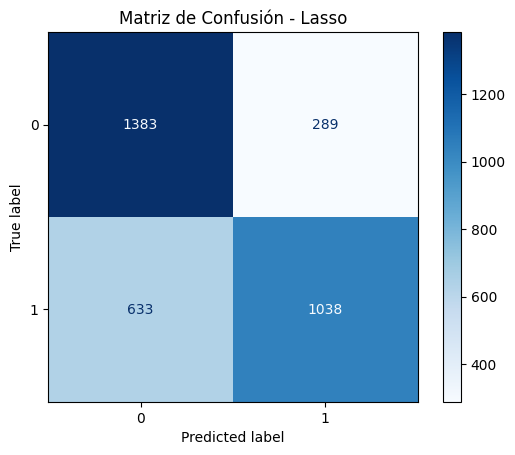


📊 Matriz de Confusión - Ridge


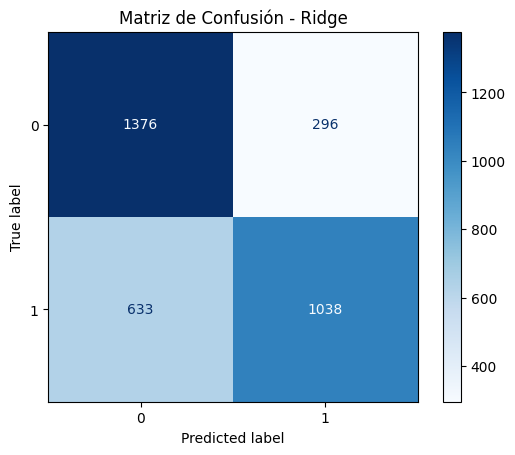

In [61]:
# Matriz de confusión
for name, model in models.items():
    # Imprime un encabezado indicando a qué modelo pertenece la matriz de confusión
    print(f"\n📊 Matriz de Confusión - {name}")

    # Genera las predicciones de clase (0 o 1) para el conjunto de prueba escalado
    y_pred = model.predict(X_test_scaled)

    # Calcula la matriz de confusión comparando las etiquetas verdaderas con las predichas
    cm = confusion_matrix(y_test, y_pred)

    # Crea el objeto para mostrar gráficamente la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)

    # Dibuja la matriz de confusión con un mapa de color azul
    disp.plot(cmap = 'Blues')

    # Asigna un título al gráfico con el nombre del modelo
    plt.title(f'Matriz de Confusión - {name}')

    # Desactiva la cuadrícula para una visualización más limpia
    plt.grid(False)

    # Muestra el gráfico en pantalla
    plt.show()

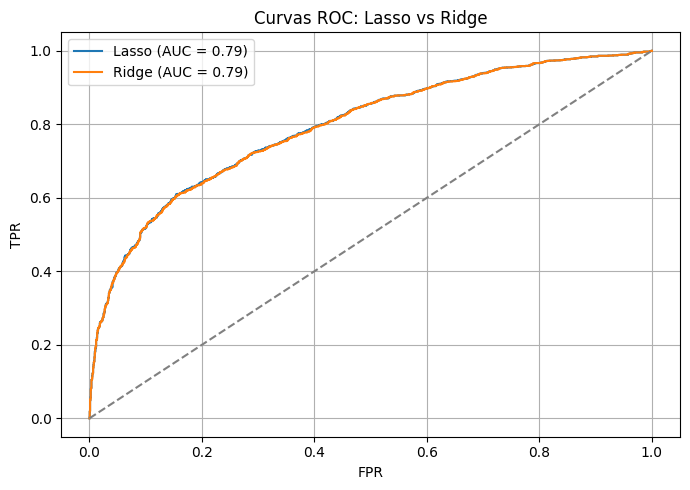

In [62]:
# Curva ROC
plt.figure(figsize = (7, 5))

# Itera sobre cada modelo para calcular y graficar su curva ROC
for name, model in models.items():
    # Obtiene las probabilidades de clase positiva (1) para el conjunto de prueba
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calcula la tasa de falsos positivos (FPR) y verdaderos positivos (TPR)
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # Calcula el AUC (Área bajo la curva ROC) como métrica de rendimiento
    auc = roc_auc_score(y_test, y_proba)

    # Dibuja la curva ROC del modelo con su nombre y AUC en la leyenda
    plt.plot(fpr, tpr, label = f"{name} (AUC = {auc:.2f})")

# Dibuja la línea diagonal de referencia (modelo aleatorio)
plt.plot([0, 1], [0, 1], '--', color = 'gray')

# Asigna título y etiquetas a los ejes
plt.title("Curvas ROC: Lasso vs Ridge")
plt.xlabel("FPR")  # Tasa de falsos positivos
plt.ylabel("TPR")  # Tasa de verdaderos positivos

# Muestra la leyenda con los nombres de los modelos y sus AUC
plt.legend()

# Activa la cuadrícula para mejor visualización
plt.grid()

# Ajusta el diseño para evitar recortes
plt.tight_layout()

# Muestra el gráfico final
plt.show()

#### <strong><font color="green">5. Implementación de técnicas de interpretabilidad</font></strong>

##### <strong><font color="DarkSeaGreen">🔸SHAP para modelo de Regresión Logística con Regularización L1 (Lasso)</font></strong>

In [63]:
# Inicializar SHAP Explainer
"""
Crea un objeto explicador SHAP para el modelo Lasso (regresión logística con regularización L1).
Usa el método 'interventional' para calcular el efecto de cada variable bajo una intervención hipotética.
"""
explainer_lasso = shap.LinearExplainer(
    lasso,                  # Modelo Lasso entrenado
    X_train_scaled,         # Datos de entrenamiento escalados (usados como background dataset)
    feature_perturbation = 'interventional'  # Tipo de perturbación para explicar la contribución de las features
)

# Calcular los valores SHAP
"""
Calcula los valores SHAP para cada observación en el conjunto de entrenamiento escalado.
Estos valores representan la contribución de cada variable en la predicción del modelo para cada observación.
"""
shap_values_lasso = explainer_lasso.shap_values(X_train_scaled)


📊 Resumen de Importancia Global - Lasso


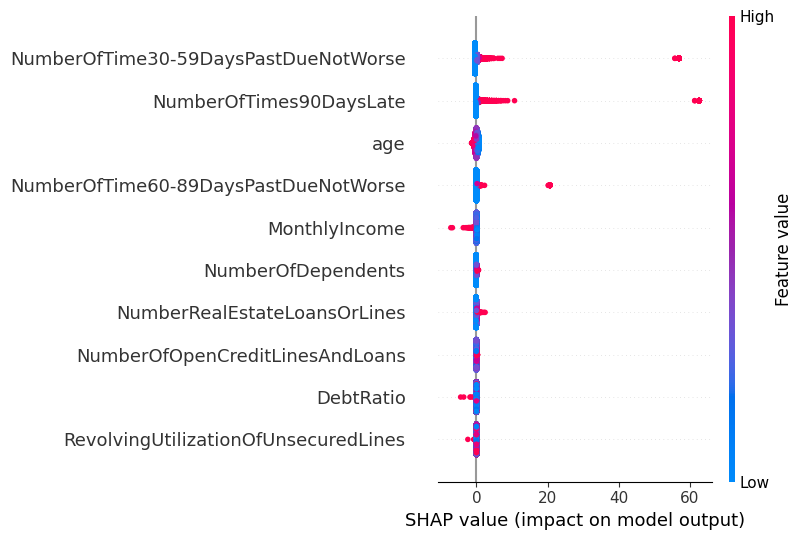

In [64]:
# Mostrar resumen de importancia global
print(f"\n📊 Resumen de Importancia Global - Lasso")

# Genera un gráfico resumen de SHAP que muestra la importancia global de cada variable
shap.summary_plot(
    shap_values_lasso,          # Valores SHAP calculados para cada observación y variable
    X_train_scaled,             # Conjunto de entrenamiento escalado (datos explicados)
    feature_names = X.columns   # Nombres originales de las variables para el eje y
)


📊 Resumen de Importancia Global - Lasso (Gráfico de barras)


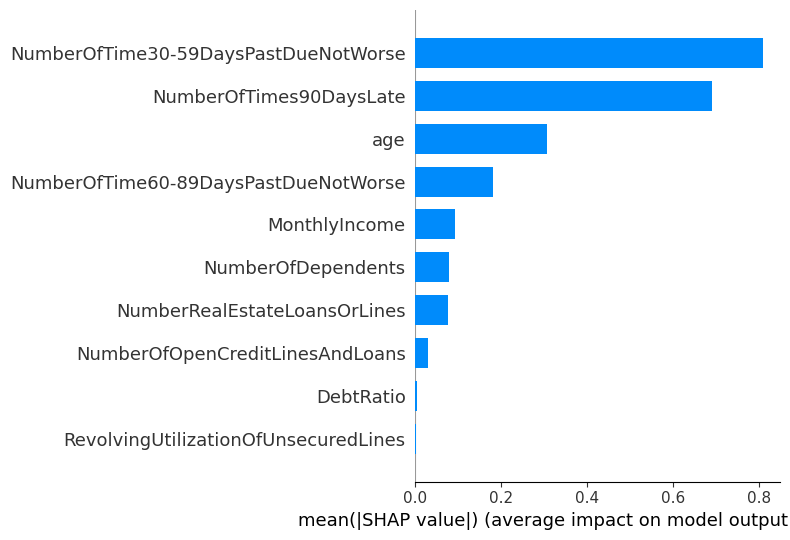

In [65]:
# Visualizar importancia global
print(f"\n📊 Resumen de Importancia Global - Lasso (Gráfico de barras)")

# Genera un gráfico resumen tipo barra que muestra la importancia global de cada variable
shap.summary_plot(
    shap_values_lasso,             # Valores SHAP del modelo Lasso
    X_train_scaled,                # Datos de entrenamiento escalados
    feature_names = X.columns,     # Nombres originales de las variables
    plot_type = "bar"              # Tipo de gráfico: barras ordenadas por importancia media
)

In [66]:
# Mostrar explicaciones locales para una observación específica
print(f"\n📊 Explicaciones locales - Lasso")

# Inicializa el entorno JS de SHAP para habilitar gráficos interactivos (como force_plot en Jupyter)
shap.initjs()

# Genera un gráfico interactivo de tipo force plot para una observación específica (la primera)
shap.force_plot(
    explainer_lasso.expected_value,     # Valor esperado (promedio base del modelo)
    shap_values_lasso[0],               # Valores SHAP de la primera observación
    feature_names = X.columns           # Nombres de las variables explicativas
)


📊 Explicaciones locales - Lasso


##### <strong><font color="DarkSeaGreen">🔸SHAP para modelo de Regresión Logística con Regularización L2 (Ridge)</font></strong>

In [67]:
# Inicializar SHAP Explainer
"""
Crea un objeto explicador SHAP para el modelo Ridge (regresión logística con regularización L2).
Usa el método 'interventional' para calcular el efecto de cada variable bajo una intervención hipotética.
"""
explainer_ridge = shap.LinearExplainer(
    ridge,                  # Modelo Ridge entrenado
    X_train_scaled,         # Datos de entrenamiento escalados (usados como background dataset)
    feature_perturbation = 'interventional'  # Tipo de perturbación para explicar la contribución de las features
)

# Calcular los valores SHAP
"""
Calcula los valores SHAP para cada observación en el conjunto de entrenamiento escalado.
Estos valores representan la contribución de cada variable en la predicción del modelo para cada observación.
"""
shap_values_ridge = explainer_ridge.shap_values(X_train_scaled)


📊 Resumen de Importancia Global - Ridge


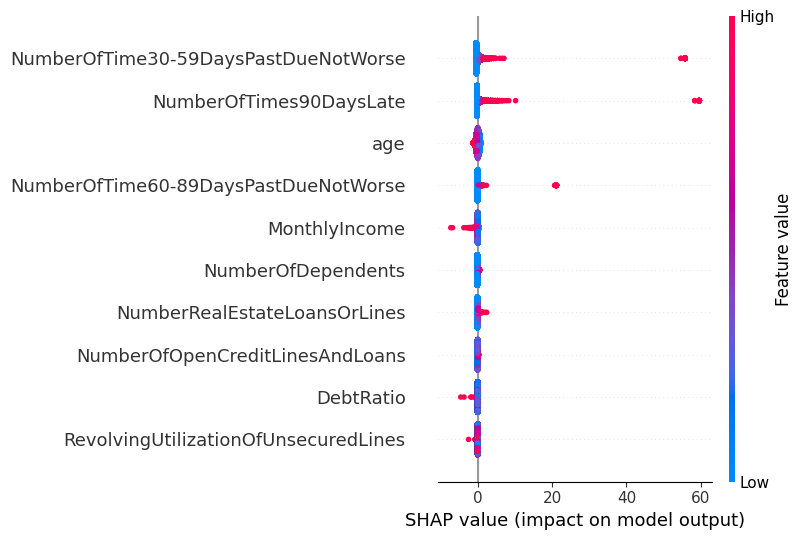

In [68]:
# Mostrar resumen de importancia global
print(f"\n📊 Resumen de Importancia Global - Ridge")

# Genera un gráfico resumen de SHAP que muestra la importancia global de cada variable
shap.summary_plot(
    shap_values_ridge,          # Valores SHAP calculados para cada observación y variable
    X_train_scaled,             # Conjunto de entrenamiento escalado (datos explicados)
    feature_names = X.columns   # Nombres originales de las variables para el eje y
)


📊 Resumen de Importancia Global - Ridge (Gráfico de barras)


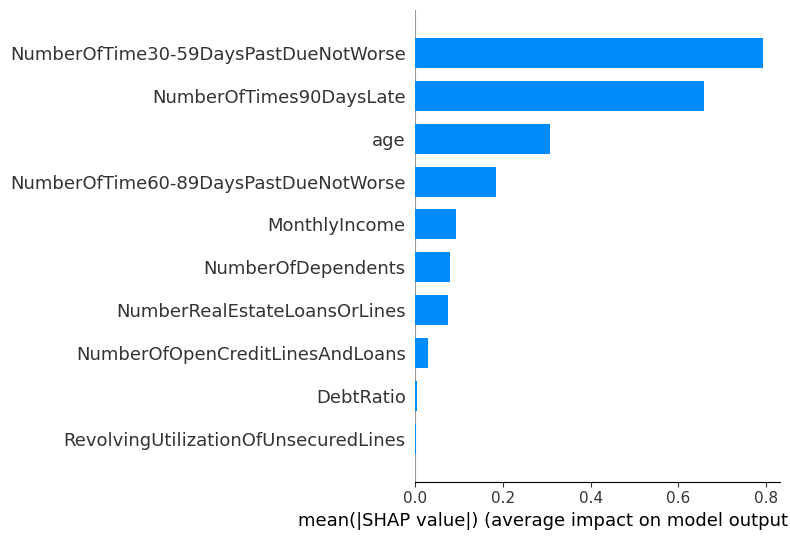

In [69]:
# Visualizar importancia global
print(f"\n📊 Resumen de Importancia Global - Ridge (Gráfico de barras)")

# Genera un gráfico resumen tipo barra que muestra la importancia global de cada variable
shap.summary_plot(
    shap_values_ridge,             # Valores SHAP del modelo Ridge
    X_train_scaled,                # Datos de entrenamiento escalados
    feature_names = X.columns,     # Nombres originales de las variables
    plot_type = "bar"              # Tipo de gráfico: barras ordenadas por importancia media
)

In [70]:
# Mostrar explicaciones locales para una observación específica
print(f"\n📊 Explicaciones locales - Ridge")

# Inicializa el entorno JS de SHAP para habilitar gráficos interactivos (como force_plot en Jupyter)
shap.initjs()

# Genera un gráfico interactivo de tipo force plot para una observación específica (la primera)
shap.force_plot(
    explainer_ridge.expected_value,     # Valor esperado (promedio base del modelo)
    shap_values_ridge[0],               # Valores SHAP de la primera observación
    feature_names = X.columns           # Nombres de las variables explicativas
)


📊 Explicaciones locales - Ridge


#### <strong><font color="green">6. Análisis de los resultados</font></strong>

🔎 **Evaluación y Comparación de Modelos con Regularización (Lasso vs Ridge)**

📊 **1. Métricas de Desempeño**

| Métrica       | Lasso | Ridge |
|---------------|-------|-------|
| Accuracy      | 0.72  | 0.72  |
| Precision (0) | 0.69  | 0.68  |
| Recall (0)    | 0.83  | 0.82  |
| Precision (1) | 0.78  | 0.78  |
| Recall (1)    | 0.62  | 0.62  |
| F1-score avg  | 0.72  | 0.72  |
| AUC-ROC       | 0.7939| 0.7931|



> 💡 Ambos modelos ofrecen resultados prácticamente equivalentes en clasificación y AUC, aunque Lasso muestra una ligera ventaja en clasificación negativa.

---

📌 **2. Matrices de Confusión**

- **Lasso**
  - Verdaderos positivos: 1038
  - Falsos negativos: 633
  - Verdaderos negativos: 1383
  - Falsos positivos: 289

- **Ridge**
  - Verdaderos positivos: 1038
  - Falsos negativos: 633
  - Verdaderos negativos: 1376
  - Falsos positivos: 296

> ✅ Lasso clasifica mejor los casos negativos (clientes "buenos") con menos falsos positivos.

---

🧠 **3. Interpretabilidad con SHAP**

- **Variables más influyentes (en ambos modelos):**
1. `NumberOfTime30-59DaysPastDueNotWorse`
2. `NumberOfTimes90DaysLate`
3. `age`
4. `NumberOfTime60-89DaysPastDueNotWorse`

- **Observaciones:**
- Atrasos en pagos están altamente correlacionados con un mayor riesgo de incumplimiento.
- Edad más baja tiende a aumentar el riesgo.
- Ingresos mensuales más altos y más líneas de crédito inmobiliario tienden a reducir el riesgo.

> 📈 SHAP permite observar tanto la **importancia global** de las variables como su **impacto individual** en cada predicción.

---

💬 **4. Reflexión sobre Interpretabilidad**

La interpretabilidad es crítica en contextos de **scoring crediticio** por varias razones:

🔍 **Transparencia y confianza:**
- Los modelos deben ser comprensibles para auditores, analistas y usuarios finales.

⚖️ **Toma de decisiones éticas:**
- Permite detectar sesgos, evitar discriminación y tomar decisiones más justas.

📜 **Cumplimiento normativo:**
- Legislaciones como **GDPR** exigen justificar las decisiones automatizadas.

> 🧩 SHAP aporta una explicación detallada de cada decisión del modelo, ayudando a identificar qué factores fueron decisivos.

---

✅ **Conclusión**

Tanto **Lasso** como **Ridge** ofrecen un rendimiento similar, pero:

- **Lasso** es preferible por su capacidad de selección de variables (algunos coeficientes se anulan).
- La **ligera mejora en precisión y AUC-ROC** de Lasso lo hace más efectivo.
- La interpretabilidad con **SHAP** resulta esencial para implementar modelos de scoring responsables y confiables.

> 🎯 Para una solución robusta en scoring crediticio, se recomienda usar:
> - Modelos penalizados (Lasso o Ridge)
> - Evaluación con métricas variadas
> - Explicabilidad mediante SHAP

---
